Populating the interactive namespace from numpy and matplotlib
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
annIds:
[0, 1, 2, 3, 4, 5, 6]
anns:
[{'id': 0, 'image_id': 0, 'category_id': 1, 'segmentation': [[209, 0, 198, 9, 182, 26, 172, 45, 168, 65, 164, 101, 164, 124, 166, 138, 173, 144, 195, 145, 204, 144, 218, 133, 222, 115, 223, 103, 224, 86, 230, 70, 230, 58, 241, 32, 245, 15, 274, 9, 304, 5, 325, 2, 367, 2, 412, 19, 421, 22, 444, 40, 458, 57, 454, 79, 462, 91, 465, 110, 464, 129, 467, 139, 456, 177, 460, 195, 483, 207, 502, 207, 506, 194, 517, 187, 523, 173, 522, 164, 525, 159, 527, 150, 522, 110, 503, 63, 486, 39, 449, 1]], 'area': 20460.0, 'bbox': [164.0, 0.0, 364.0, 208.0], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 2, 'segmentation': [[162, 277, 146, 277, 137, 285, 130, 305, 117, 334, 118, 382, 137, 398, 174, 428, 207, 448, 256, 459, 315, 469, 367, 463, 428, 429, 449, 408, 480, 362, 483, 352, 465, 334, 439, 335, 430, 348, 429, 

D:\ProgramData\Miniconda3\envs\mrcnn\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


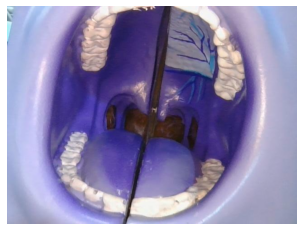

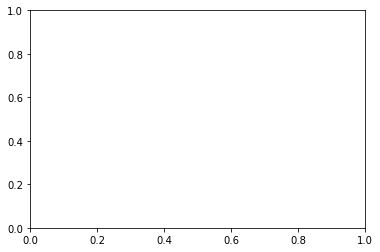

In [5]:
from pycocotools import mask, coco
from pycocotools.coco import COCO
import json
import matplotlib.pyplot as plt
%pylab inline
import cv2
import numpy as np
import PIL.Image as Image


file = "../../oral_dataset/annotations.json"
pic_path = "../../oral_dataset/JPEGImages/0.jpg"
im = cv2.imread(pic_path)
plt.axis('off')
plt.imshow(im)
plt.show()
f = open(file, encoding="utf-8")
json = json.load(f)
segm = json['annotations'][0]['segmentation']
cc = COCO(file)
imgInfo = cc.loadImgs(0)
annIds = cc.getAnnIds(imgIds=0)
print("annIds:")
print(annIds)
anns = cc.loadAnns(annIds)
print("anns:")
print(anns)
cc.showAnns(anns)
# mask = cc.annToMask(anns[3])
# plt.imshow(mask)
# plt.axis('off')